# Fake News Classifier


Copyright @ 2020 **ABCOM Information Systems Pvt. Ltd.** All Rights Reserved.

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.

See the License for the specific language governing permissions and limitations under the License.

Datasource: https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Downloading data

In [ ]:
!wget https://github.com/abcom-mltutorials/FakeNews/blob/master/572515_1037534_compressed_Fake.csv.zip?raw=true
!wget https://github.com/abcom-mltutorials/FakeNews/blob/master/572515_1037534_compressed_True.csv.zip?raw=true

--2020-08-18 12:39:30--  https://github.com/abcom-mltutorials/FakeNews/blob/master/572515_1037534_compressed_Fake.csv.zip?raw=true
Resolving github.com (github.com)... 140.82.118.4
Connecting to github.com (github.com)|140.82.118.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/abcom-mltutorials/FakeNews/raw/master/572515_1037534_compressed_Fake.csv.zip [following]
--2020-08-18 12:39:30--  https://github.com/abcom-mltutorials/FakeNews/raw/master/572515_1037534_compressed_Fake.csv.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/abcom-mltutorials/FakeNews/master/572515_1037534_compressed_Fake.csv.zip [following]
--2020-08-18 12:39:30--  https://raw.githubusercontent.com/abcom-mltutorials/FakeNews/master/572515_1037534_compressed_Fake.csv.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.

In [ ]:
!unzip "/content/572515_1037534_compressed_Fake.csv.zip?raw=true"
!unzip "/content/572515_1037534_compressed_True.csv.zip?raw=true"

Archive:  /content/572515_1037534_compressed_Fake.csv.zip?raw=true
  inflating: Fake.csv                
Archive:  /content/572515_1037534_compressed_True.csv.zip?raw=true
  inflating: True.csv                


## Examining data

In [ ]:
fake = pd.read_csv("Fake.csv")
true = pd.read_csv("True.csv")
print(fake.head())
print(true.head())

                                               title  ...               date
0   Donald Trump Sends Out Embarrassing New Year’...  ...  December 31, 2017
1   Drunk Bragging Trump Staffer Started Russian ...  ...  December 31, 2017
2   Sheriff David Clarke Becomes An Internet Joke...  ...  December 30, 2017
3   Trump Is So Obsessed He Even Has Obama’s Name...  ...  December 29, 2017
4   Pope Francis Just Called Out Donald Trump Dur...  ...  December 25, 2017

[5 rows x 4 columns]
                                               title  ...                date
0  As U.S. budget fight looms, Republicans flip t...  ...  December 31, 2017 
1  U.S. military to accept transgender recruits o...  ...  December 29, 2017 
2  Senior U.S. Republican senator: 'Let Mr. Muell...  ...  December 31, 2017 
3  FBI Russia probe helped by Australian diplomat...  ...  December 30, 2017 
4  Trump wants Postal Service to charge 'much mor...  ...  December 29, 2017 

[5 rows x 4 columns]


## Print a sample headline

In [ ]:
print("Fake news headline: "+fake.iloc[0,0])
print("True news headline: "+true.iloc[0,0])

Fake news headline:  Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing
True news headline: As U.S. budget fight looms, Republicans flip their fiscal script


## Check dataset sizes

In [ ]:
print(fake.shape)
print(true.shape)

(23481, 4)
(21417, 4)


## Shrink datasets

In [ ]:
fake = fake[:11740]
true = true[:10708]

# Preprocess datasets

## Add is_fake column

In [ ]:
# Entering 1 for fake and 0 for true in is_fake 
# column for both the dataframes
fake_news = []
for row in range(len(fake)):
  fake_news.append("fake")
fake["is_fake"] = fake_news

fake_news = []
for row in range(len(true)):
  fake_news.append("true")
true["is_fake"] = fake_news

## Merge two datasets

In [ ]:
news = pd.merge(fake,true, how = "outer")

## Check class distribution

fake    11740
true    10708
Name: is_fake, dtype: int64


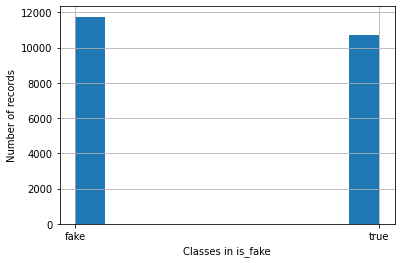

In [ ]:
classes = news["is_fake"]
print(classes.value_counts())
classes.hist()
plt.xlabel("Classes in is_fake")
plt.ylabel("Number of records")
plt.show()

## Encode is_fake column

In [ ]:
# convert class labels to binary values, 
# 0 = fake and 1 = true
encoder = LabelEncoder()
is_fake = encoder.fit_transform(classes)

## Extract headlines

In [ ]:
headlines = news["title"]
print(headlines[:10])

0     Donald Trump Sends Out Embarrassing New Year’...
1     Drunk Bragging Trump Staffer Started Russian ...
2     Sheriff David Clarke Becomes An Internet Joke...
3     Trump Is So Obsessed He Even Has Obama’s Name...
4     Pope Francis Just Called Out Donald Trump Dur...
5     Racist Alabama Cops Brutalize Black Boy While...
6     Fresh Off The Golf Course, Trump Lashes Out A...
7     Trump Said Some INSANELY Racist Stuff Inside ...
8     Former CIA Director Slams Trump Over UN Bully...
9     WATCH: Brand-New Pro-Trump Ad Features So Muc...
Name: title, dtype: object


## Remove punctuation

In [ ]:
headlines = headlines.str.replace(r'[^\w\d\s]', ' ')

## Change words to lowercase

In [ ]:
headlines = headlines.str.lower() 

## Remove stopwords

In [ ]:
#Removing stopwords from news headlines
nltk.download("stopwords")
stop_words = set(stopwords.words("english")) 
headlines = headlines.apply(lambda x : " ".
                            join(word for word in x.split() 
                            if word not in stop_words))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Stemming

In [ ]:
# Remove affixes to give stems using a Porter stemmer
ps = nltk.PorterStemmer()
headlines = headlines.apply(lambda x: ' '.join(ps.stem(word) 
                            for word in x.split()))

# Generating Features

In [ ]:
# download tokenizer
nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# creating a collection of all the words
all_words = []

for line in headlines:
    words = word_tokenize(line)
    for word in words:
        all_words.append(word)

print("Number of words: ", len(all_words))

Number of words:  206497


In [ ]:
# extract unique words
all_words = nltk.FreqDist(all_words)

In [ ]:
# print the total number of words and the 15 most common words
print('Number of words: {}'.format(len(all_words)))
print('Most common words: {}'.format(all_words.most_common(15)))

Number of words: 10174
Most common words: [('trump', 11274), ('video', 4022), ('u', 3198), ('say', 1980), ('republican', 1602), ('hous', 1584), ('senat', 1416), ('obama', 1401), ('watch', 1279), ('white', 1130), ('presid', 981), ('clinton', 978), ('tweet', 970), ('bill', 919), ('democrat', 886)]


## Narrowing down the features list

In [ ]:
# use the 2300 most common words as features
word_features = list(all_words.keys())[:2300]

## Function for finding features in a given headline

In [ ]:
# The find_features function will determine which of 
# the 2300 word features are contained in the headlines
def find_features(headline):
    words = word_tokenize(headline)
    features = {}
    for word in word_features:
        features[word] = (word in words)

    return features

# Let's see an example
features = find_features(headlines[0])
for key, value in features.items():
    if value == True:
        print(key)

donald
trump
send
embarrass
new
year
eve
messag
disturb


Note: The code below is delicate as we are using shuffle function and generating featuresset. If you run into any error then do not re-run the cell.
Instead restart the kernel and run all the cells again.

## Create a Features set using entire dataset

In [ ]:
# Now lets do it for all the headlines
headlines = list(zip(headlines, is_fake))
# define a seed for reproducibility
seed = 1
np.random.seed = seed
np.random.shuffle(headlines)

# call find_features function for each headline
featuresets = [(find_features(headline), category) 
                for (headline, category) in headlines]


# Creating datasets

In [ ]:
# we can split the featuresets into training and testing datasets using model_selection in sklearn
# split the data into training and testing datasets

training, testing = train_test_split(featuresets, 
                                     test_size = 0.25, 
                                     random_state=seed)

# Training on Multiple Classifiers 

In [ ]:
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, max_error

In [ ]:
# Define models to train
names = ["Logistics Regression",
         "K Nearest Neighbors", 
         "Decision Tree", 
         "Random Forest",  
         "SGD Classifier",
         "Naive Bayes", 
         "SVM Linear"]

classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    SGDClassifier(max_iter = 100),
    MultinomialNB(),
    SVC(kernel = 'linear')
]

models = zip(names, classifiers)

for name, model in models:
    nltk_model = SklearnClassifier(model)
    nltk_model.train(training)
    accuracy = nltk.classify.accuracy(nltk_model, testing)*100
    print("{} Accuracy: {}".format(name, accuracy))

Logistics Regression Accuracy: 92.96151104775481
K Nearest Neighbors Accuracy: 63.934426229508205
Decision Tree Accuracy: 87.08125445473985
Random Forest Accuracy: 90.68068424803991
SGD Classifier Accuracy: 93.01496792587312
Naive Bayes Accuracy: 91.21525302922309
SVM Linear Accuracy: 92.8367783321454


# VotingClassifier

In [ ]:
# Ensemble methods - Voting classifier
from sklearn.ensemble import VotingClassifier

names = ["Logistics Regression",
         "K Nearest Neighbors", 
         "Decision Tree", 
         "Random Forest",  
         "SGD Classifier",
         "Naive Bayes", 
         "SVM Linear"]

classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    SGDClassifier(max_iter = 100),
    MultinomialNB(),
    SVC(kernel = 'linear')
]
models = list(zip(names, classifiers))

ensemble = SklearnClassifier(VotingClassifier(estimators = models, voting = 'hard', n_jobs = -1))
ensemble.train(training)
accuracy = nltk.classify.accuracy(nltk_model, testing)*100
print("Voting Classifier: Accuracy: {}".format(accuracy))

Voting Classifier: Accuracy: 92.8367783321454


# Model Evaluation

In [ ]:
# make class label prediction for testing set
headline_features, labels = zip(*testing)
prediction = ensemble.classify_many(headline_features)

## Classification report

In [ ]:
# classification report
print(classification_report(labels, prediction))

              precision    recall  f1-score   support

           0       0.96      0.90      0.93      2941
           1       0.90      0.96      0.93      2671

    accuracy                           0.93      5612
   macro avg       0.93      0.93      0.93      5612
weighted avg       0.93      0.93      0.93      5612



## Confusion matrix

In [ ]:
pd.DataFrame(
    confusion_matrix(labels, prediction),
    index = [['actual', 'actual'], ['fake', 'true']],
    columns = [['predicted', 'predicted'], ['fake', 'true']])

predicted      
                 fake  true
actual fake      2647   294
       true       105  2566

# Classifying unseen news

In [ ]:
print(ensemble.classify(find_features("Alia Bhatt’s Sadak 2 the most disliked trailer on YouTube amid nepotism debate, fans demand justice for Sushant Singh Rajput"))) 

1


In [ ]:
print(ensemble.classify(find_features("India Air crash survivor recounts final minutes in plane")))

1


In [ ]:
print(ensemble.classify(find_features("Kerala plane crash: 92 injured passengers discharged from hospitals after 'obtaining complete fitness'")))

1


# Classifying news stream

In [ ]:
# Make a list of news
newslist = []
newslist.append("NASA tweets beautiful pictures of Mars. They may make you gasp in wonder")
newslist.append("How visually impaired woman beat the odds to crack UPSC exam. She’s inspiring many including Mohammad Kaif")
newslist.append("Russia registers the world's first Covid-19 vaccine, Putin says his daughter was given a shot")
newslist.append("2020 is the year to stay alive, and don't think of profit or loss")
newslist.append("Democratic presidential candidate Joe Biden and running mate Kamala Harris have attacked 'whining' President Donald Trump as an incompetent leader who has left the US 'in tatters'.")
newslist

['NASA tweets beautiful pictures of Mars. They may make you gasp in wonder',
 'How visually impaired woman beat the odds to crack UPSC exam. She’s inspiring many including Mohammad Kaif',
 "Russia registers the world's first Covid-19 vaccine, Putin says his daughter was given a shot",
 "2020 is the year to stay alive, and don't think of profit or loss",
 "Democratic presidential candidate Joe Biden and running mate Kamala Harris have attacked 'whining' President Donald Trump as an incompetent leader who has left the US 'in tatters'."]

In [ ]:
# Then make a dataframe of single column using the list
news_classification = pd.DataFrame(newslist, columns=["News"])
news_classification

NameError: ignored

In [ ]:
# Then making predictions and storing in another list. In is_true column 0 - fake and 1 - true
is_true = []
for i in newslist:
  is_true.append(ensemble.classify(find_features(i)))

In [ ]:
# Finally appending the prediction to dataframe and printing it altogether
news_classification["is_true"] = is_true
news_classification

,News,is_true
0,NASA tweets beautiful pictures of Mars. They m...,1
1,How visually impaired woman beat the odds to c...,0
2,Russia registers the world's first Covid-19 va...,1
3,"2020 is the year to stay alive, and don't thin...",0
4,Democratic presidential candidate Joe Biden an...,1
